In [1]:
from dataman.audio_processing import *

from librosa.feature import mfcc
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from umap import UMAP

import time

In [13]:
def save_fig(fig_id, tight_layout=True):
    path = os.path.join("./figs/" + fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Renewing the data within the database

The first batch of data collected for the database (in "datasets/keystrokes_00") contained too few, too diversified sound data for each key type that no meaningful progress could be made for the supervised proof-of-concept model. To fix this, the data within the database will be overhauled from scratch by recollecting data for each key type once again, with a particular focus on consistency of keystroke sound. By artifically constraining the variance of sound data for each key type, I hope to have an easier time generating meaningful output for the proof of concept.

### Extracting keystroke data from raw WAV files

In [3]:
keystroke_data = collect_keystroke_data('/env/datasets/keystrokes/', output=True)

> Reading files from /env/datasets/keystrokes/a/ for key "a"
  > Extracting keystrokes from "a-x.wav" => Collected 123 keystrokes
> Reading files from /env/datasets/keystrokes/b/ for key "b"
  > Extracting keystrokes from "b-x.wav" => Collected 108 keystrokes
> Reading files from /env/datasets/keystrokes/c/ for key "c"
  > Extracting keystrokes from "c-x.wav" => Collected 156 keystrokes
> Reading files from /env/datasets/keystrokes/d/ for key "d"
  > Extracting keystrokes from "d-x.wav" => Collected 150 keystrokes
> Reading files from /env/datasets/keystrokes/e/ for key "e"
  > Extracting keystrokes from "e-x.wav" => Collected 159 keystrokes
> Reading files from /env/datasets/keystrokes/f/ for key "f"
  > Extracting keystrokes from "f-x.wav" => Collected 195 keystrokes
> Reading files from /env/datasets/keystrokes/g/ for key "g"
  > Extracting keystrokes from "g-x.wav" => Collected 153 keystrokes
> Reading files from /env/datasets/keystrokes/h/ for key "h"
  > Extracting keystrokes fro

### Creating a table in local Postgres db and storing keystroke data (only required the first time)

In [4]:
create_keystroke_table()

In [5]:
store_keystroke_data(keystroke_data, os.environ['TEST_DATABASE_URL'])

### Loading stored data from database

In [2]:
data, labels_int, labels_str = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

In [3]:
data

array([[ 1086,  2269,  3287, ...,    17,    17,     8],
       [-1099,  -858,  -332, ...,    -5,     1,    11],
       [  950,   421,  -471, ...,   -34,   -33,   -30],
       ...,
       [ -724,  -949,   539, ...,     0,    -4,    -5],
       [ -545,  -933,  -223, ...,    -7,    -9,    -7],
       [ -828, -1149,   125, ...,    -7,    -5,    -3]])

In [4]:
labels_int

array([ 0,  0,  0, ..., 28, 28, 28])

In [5]:
labels_str

array(['a', 'a', 'a', ..., 'enter', 'enter', 'enter'], dtype='<U6')

## Supervised Training (Initial Attempt)

In [28]:
scaled_data = scale_keystroke_data(data)

In [21]:
# 90% training, 10% testing
training_count = int(len(scaled_data) * 0.9)
x_train, x_test = scaled_data[:training_count], scaled_data[training_count:]
y_train, y_test = labels[:training_count], labels[training_count:]

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
3987/3987 [==============================] - 2s 600us/sample - loss: 3.7046 - accuracy: 0.0296
Epoch 2/5
3987/3987 [==============================] - 1s 298us/sample - loss: 3.3659 - accuracy: 0.0416
Epoch 3/5
3987/3987 [==============================] - 1s 306us/sample - loss: 3.3647 - accuracy: 0.0426
Epoch 4/5
3987/3987 [==============================] - 1s 299us/sample - loss: 3.3637 - accuracy: 0.0426
Epoch 5/5
444/444 [==============================] - 0s 402us/sample - loss: 3.3636 - accuracy: 0.0563


[3.3636162946890065, 0.056306306]

The classifying accuracy is ~5.6%, which is pretty low. But I guess this is to be expected due to how similar certain groups of key types sound relative to each other. A logical next step seems to be clustering and visualizing each keystroke to observe whether the the low classifying accuracy is due to keystrokes being extremely indistinguishable or clusters being distinguishable, but lack enough variance between similar clusters.

## Clustering the Data (Initial Attempt)

Clustering the data naively into 29 clusters within a 13,230 dimension space (like below) would likely take a absurdly long time. Instead, I should preprocess the data beforehand to reduce the number of dimensions. The important aspects of each keystroke data are the points and widths of the peaks. Values below the silence threshold don't matter at all, so those portions can just be regarded as "0". So maybe sample each data in with lower frequency, with higher frequency around the first 0.2 seconds or so to capture the peak details.

In [ ]:
kmeans = KMeans(n_clusters=29, random_state=0).fit(scaled_data)

After some research, I've determined that t-SNE (t-Distributed Stochastic Neighbor Embedding) is a good candidate for visualizing the keystroke data within a 2 or 3 dimensional space. sklearn already has it implemented, so I will attempt to use that in order to proceed with my project.

In [15]:
data, labels_int, labels_str = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

### t-SNE Clustering

In [18]:
scaled_data = MinMaxScaler().fit_transform(data)
t0 = time.time()
data_embedded = TSNE(perplexity=5.0, n_iter=5000).fit_transform(scaled_data)
t1 = time.time()
print(f'Total time elapsed: {t1 - t0}s')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Total time elapsed: 430.8447461128235s


In [22]:
scaled_data

array([[0.55800229, 0.85026551, 0.65004875, ..., 0.62585034, 0.64788732,
        0.576     ],
       [0.36554215, 0.66779483, 0.48967473, ..., 0.47619048, 0.53521127,
        0.6       ],
       [0.54602308, 0.74242866, 0.48351502, ..., 0.27891156, 0.29577465,
        0.272     ],
       ...,
       [0.39857306, 0.66248468, 0.52827262, ..., 0.51020408, 0.5       ,
        0.472     ],
       [0.41433982, 0.66341833, 0.49450501, ..., 0.46258503, 0.46478873,
        0.456     ],
       [0.38941249, 0.65081403, 0.50992644, ..., 0.46258503, 0.49295775,
        0.488     ]])

In [19]:
data_embedded

array([[   0.71646637,    1.6379142 ],
       [-111.89546   ,  -32.257053  ],
       [ -50.46869   ,  -80.97209   ],
       ...,
       [  10.397856  ,   -1.0549328 ],
       [  11.304558  ,   -0.61472476],
       [   7.957733  ,    0.19473097]], dtype=float32)

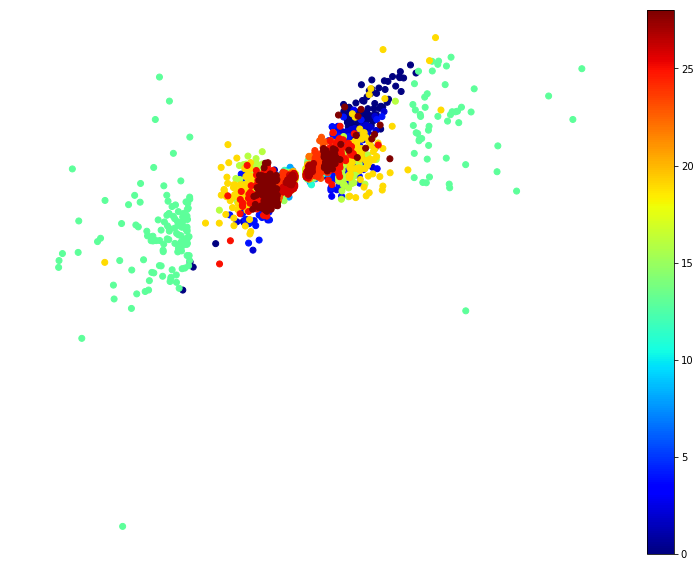

In [8]:
plt.figure(figsize=(13, 10))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=labels, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

### PCA Clustering

In [6]:
data, labels_int, labels_str = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


PCA took 1.5743823051452637s
Saving figure pca-fail


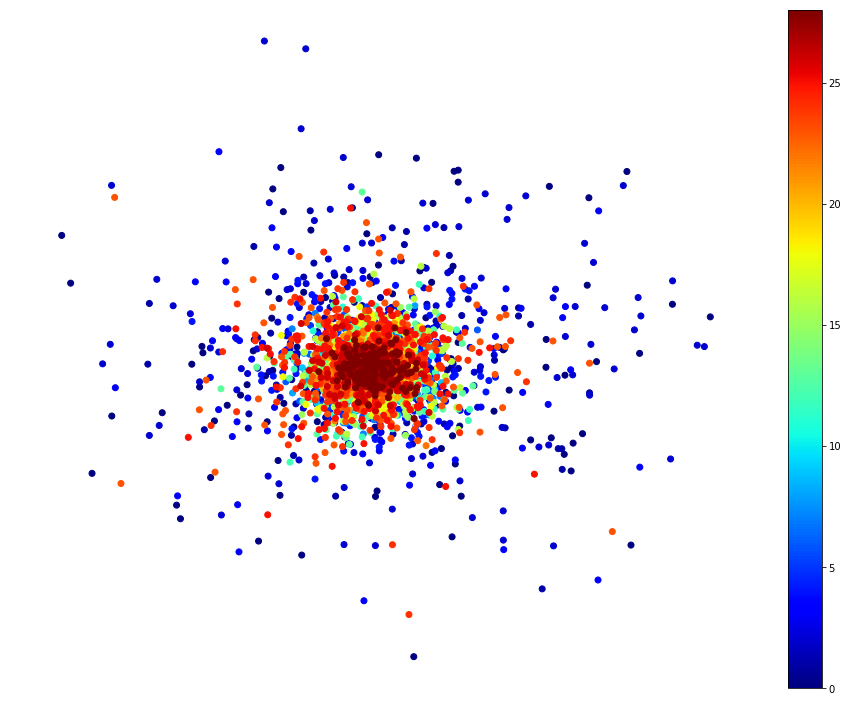

In [14]:
scaled_data = MinMaxScaler().fit_transform(data)
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(scaled_data)
t1 = time.time()
print(f'PCA took {t1 - t0}s')
plt.figure(figsize=(13, 10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=labels_int, cmap='jet')
plt.axis('off')
plt.colorbar()
save_fig('pca-fail')
plt.show()

## Better Visualization

In [16]:
def plot_keystrokes(X, y_int, y_str, min_distance=0.05, images=None, figsize=(13, 10)):
    """Plot keystrokes data X in 2D plane with graphical labels.
    
    Mostly copied from plot_digits() function from:
    https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb
    """
    X_norm = MinMaxScaler().fit_transform(X)
    # Create list of coordinates plotted so far.
    # Initialized with point plotted far from start to bypass if-conditions
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = plt.cm.get_cmap('jet')
    labels = np.unique(y_int)
    for label in labels:
        plt.scatter(X_norm[y_int == label, 0], X_norm[y_int == label, 1], c=[cmap(label / 28)])
    plt.axis('off')
    ax = plt.gcf().gca() # get current axes in current figure
    for index, image_coord in enumerate(X_norm):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                if images is None:
                    plt.text(image_coord[0], image_coord[1], y_str[index],
                             color=cmap(y_int[index] / 9), fontdict={"weight": "bold", "size": 16})
                else:
                    image = images[index]
                    imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                    ax.add_artist(imagebox)

Saving figure tsne-fail


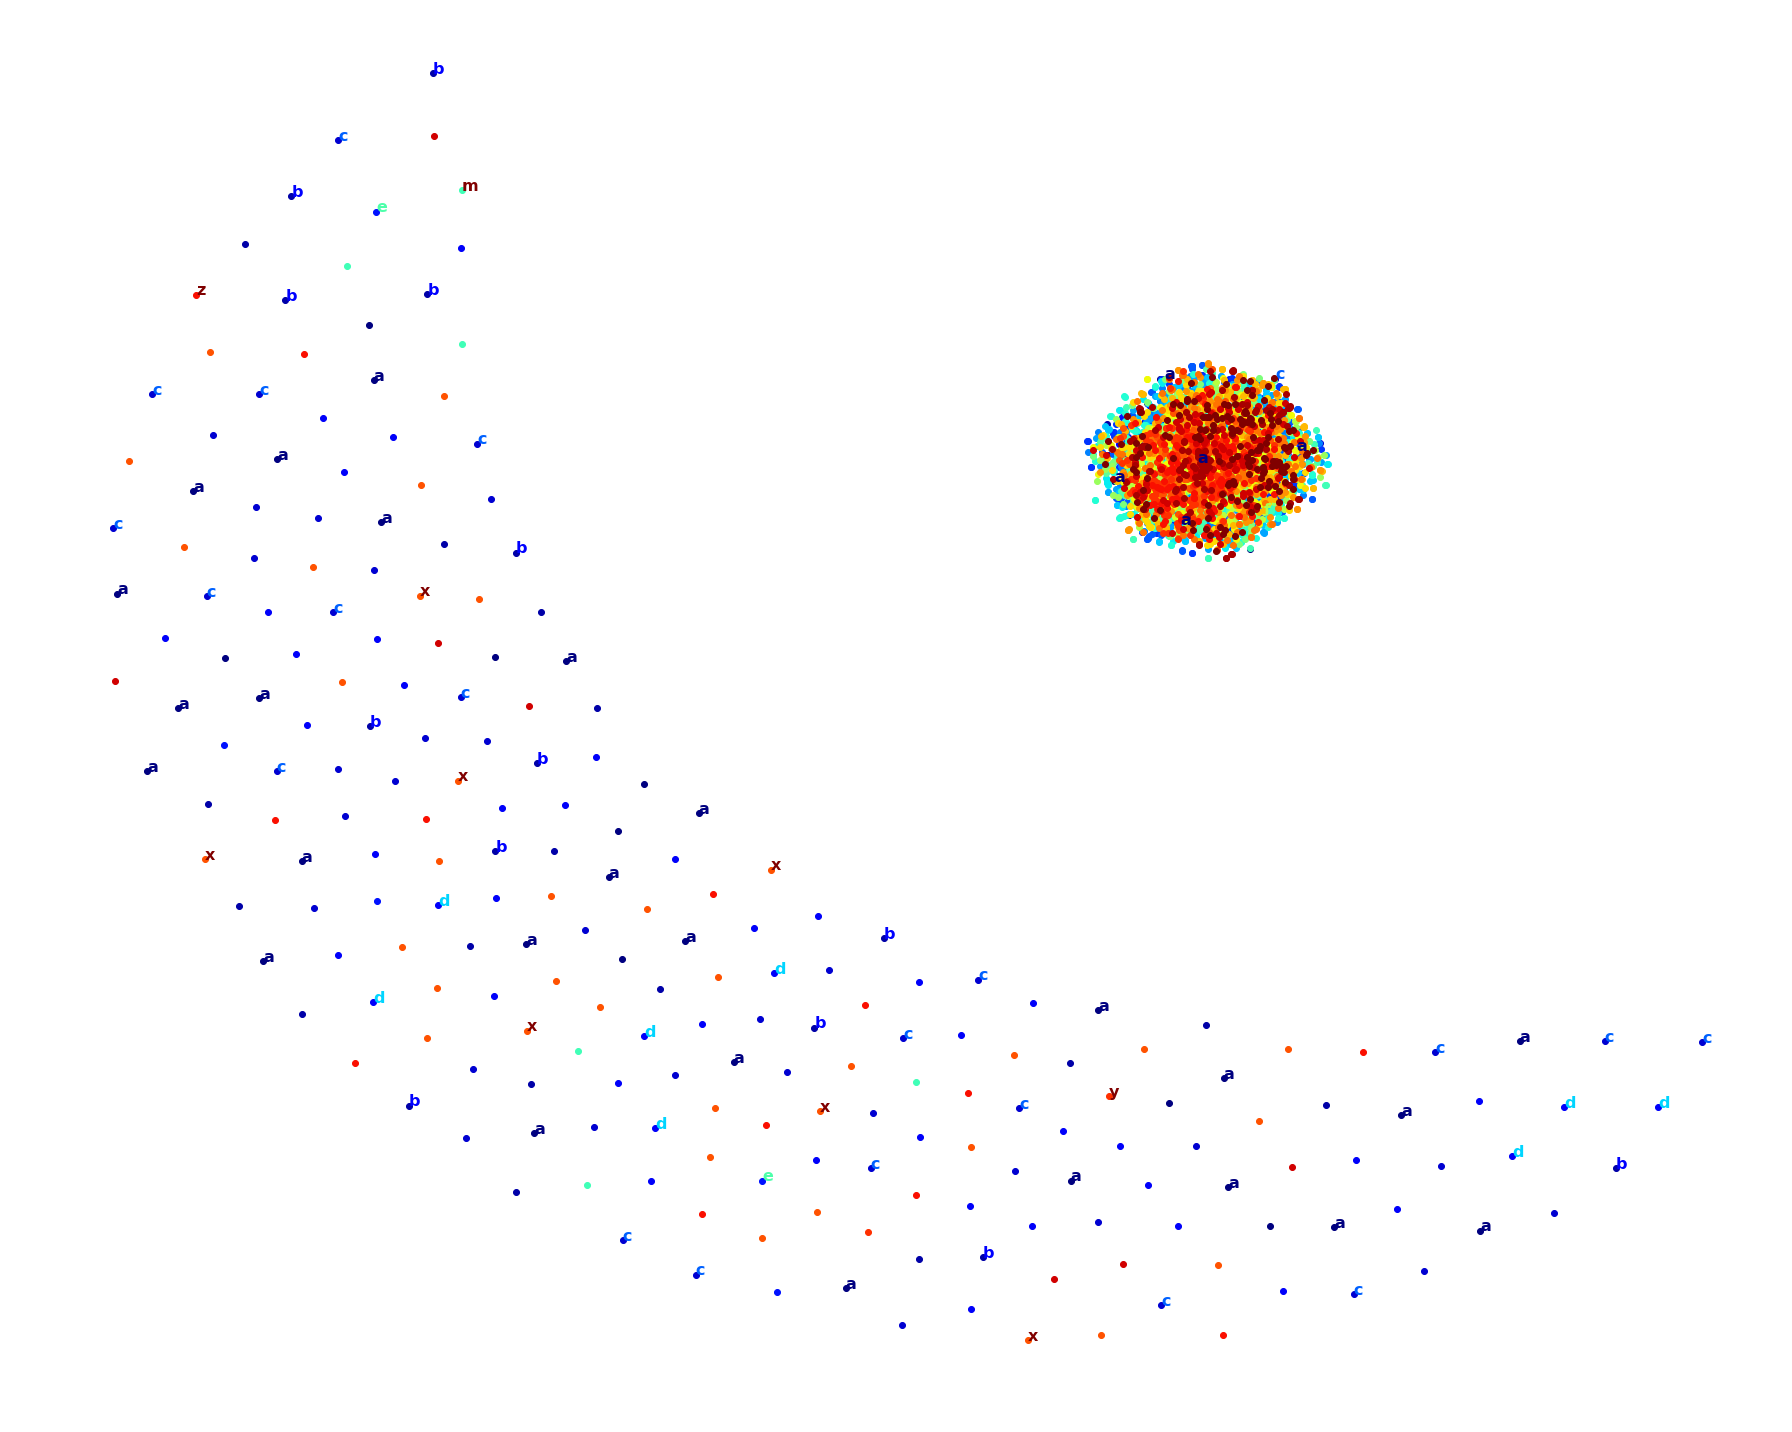

In [21]:
plot_keystrokes(data_embedded, labels_int, labels_str, figsize=(25, 20))
save_fig('tsne-fail')

## Clustering just 'spacebar' and 'a' keys

Because there is no identifiable clustering in the renderings above, I will start by using just the datasets for the 'a' key and spacebar. Once I devise an effective method for dimension-reduction and clustering these two keys, I will attempt to apply that same process to all 29 keys and observe its effectiveness.

In [25]:
idx = (labels == 0) | (labels == 26)
data_subset = data[idx]
labels_subset = labels[idx]

In [26]:
scaled_data_subset = MinMaxScaler().fit_transform(data_subset)
t0 = time.time()
embedded_data_subset = TSNE().fit_transform(scaled_data_subset)
t1 = time.time()
print(f'Elapsed time: {t1 - t0}s')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Elapsed time: 2.2204086780548096s


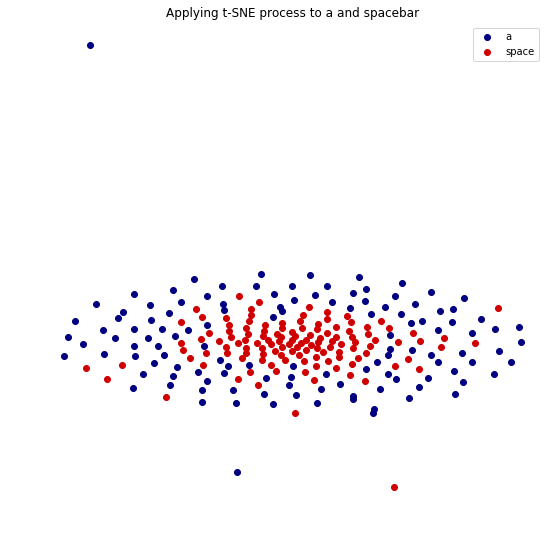

In [27]:
cmap = plt.cm.get_cmap('jet')
plt.figure(figsize=(9,9))
for digit in (0, 26):
    plt.scatter(embedded_data_subset[labels_subset == digit, 0], 
                embedded_data_subset[labels_subset == digit, 1],
                c=[cmap(digit / 28)])
plt.title('Applying t-SNE process to a and spacebar')
plt.legend({'a', 'space'})
plt.axis('off')
plt.show()

### Clustering Attempt with UMAP

In [28]:
idx = (labels == 0) | (labels == 26)
data_subset = data[idx]
labels_subset = labels[idx]

In [29]:
scaled_data_subset = MinMaxScaler().fit_transform(data_subset)
t0 = time.time()
embedded_data_subset = UMAP().fit_transform(scaled_data_subset)
t1 = time.time()
print(f'Elapsed time: {t1 - t0}s')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Elapsed time: 5.855605840682983s


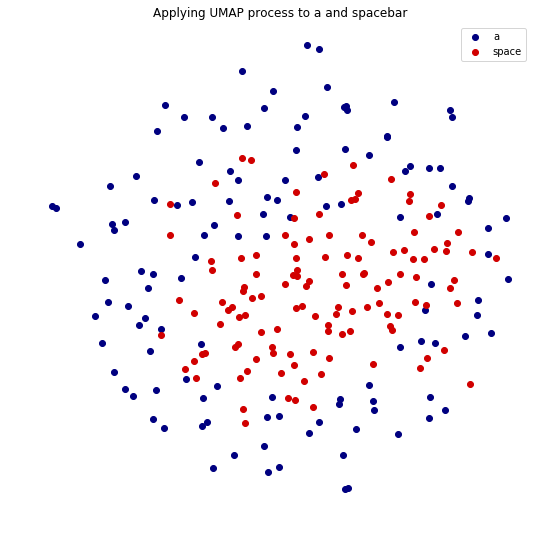

In [30]:
cmap = plt.cm.get_cmap('jet')
plt.figure(figsize=(9,9))
for digit in (0, 26):
    plt.scatter(embedded_data_subset[labels_subset == digit, 0], 
                embedded_data_subset[labels_subset == digit, 1],
                c=[cmap(digit / 28)])
plt.title('Applying UMAP process to a and spacebar')
plt.legend({'a', 'space'})
plt.axis('off')
plt.show()

### MFCC for Preprocessing before Clustering

In [29]:
def extract_features(keystroke):
    """Return a frequency-based feature vector for given keystroke."""
    spec = mfcc(y=keystroke.astype(float),
                sr=44100,
                n_mfcc=16,
                n_fft=441, # n_fft=220 for 10ms window
                hop_length=110, # hop_length=110 for ~2.5ms
               )
    return spec.flatten()

In [4]:
data, labels_int, labels_str = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

In [17]:
idx = (labels_int == 26) | (labels_int == 0)
data_subset = data[idx]
labels_subset = labels_int[idx]

In [19]:
processed_data_subset = np.array([extract_features(key) for key in data_subset])

In [26]:
scaled_data_subset = MinMaxScaler().fit_transform(processed_data_subset)
t0 = time.time()
embedded_data_subset = TSNE().fit_transform(scaled_data_subset)
t1 = time.time()
print(f'Elapsed time: {t1 - t0}s')

Elapsed time: 0.8780272006988525s


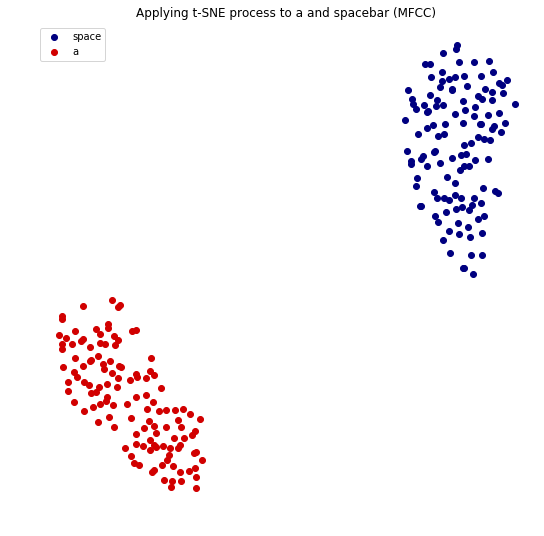

In [27]:
cmap = plt.cm.get_cmap('jet')
plt.figure(figsize=(9,9))
for digit in (0, 26):
    plt.scatter(embedded_data_subset[labels_subset == digit, 0], 
                embedded_data_subset[labels_subset == digit, 1],
                c=[cmap(digit / 28)])
plt.title('Applying t-SNE process to a and spacebar (MFCC)')
plt.legend({'a', 'space'})
plt.axis('off')
plt.show()

### Applying t-SNE to MFCC's for every key

In [30]:
# Run extract_features on every key type, instead of just 'a' and 'space'
processed_data = np.array([extract_features(key) for key in data])

/usr/local/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


4431
4431
1936


In [27]:
scaled_data = MinMaxScaler().fit_transform(processed_data)
t0 = time.time()
data_embedded = TSNE().fit_transform(scaled_data)
t1 = time.time()
print(f'Total time elapsed: {t1 - t0}s')

Total time elapsed: 72.53627371788025s


Saving figure tsne-success2


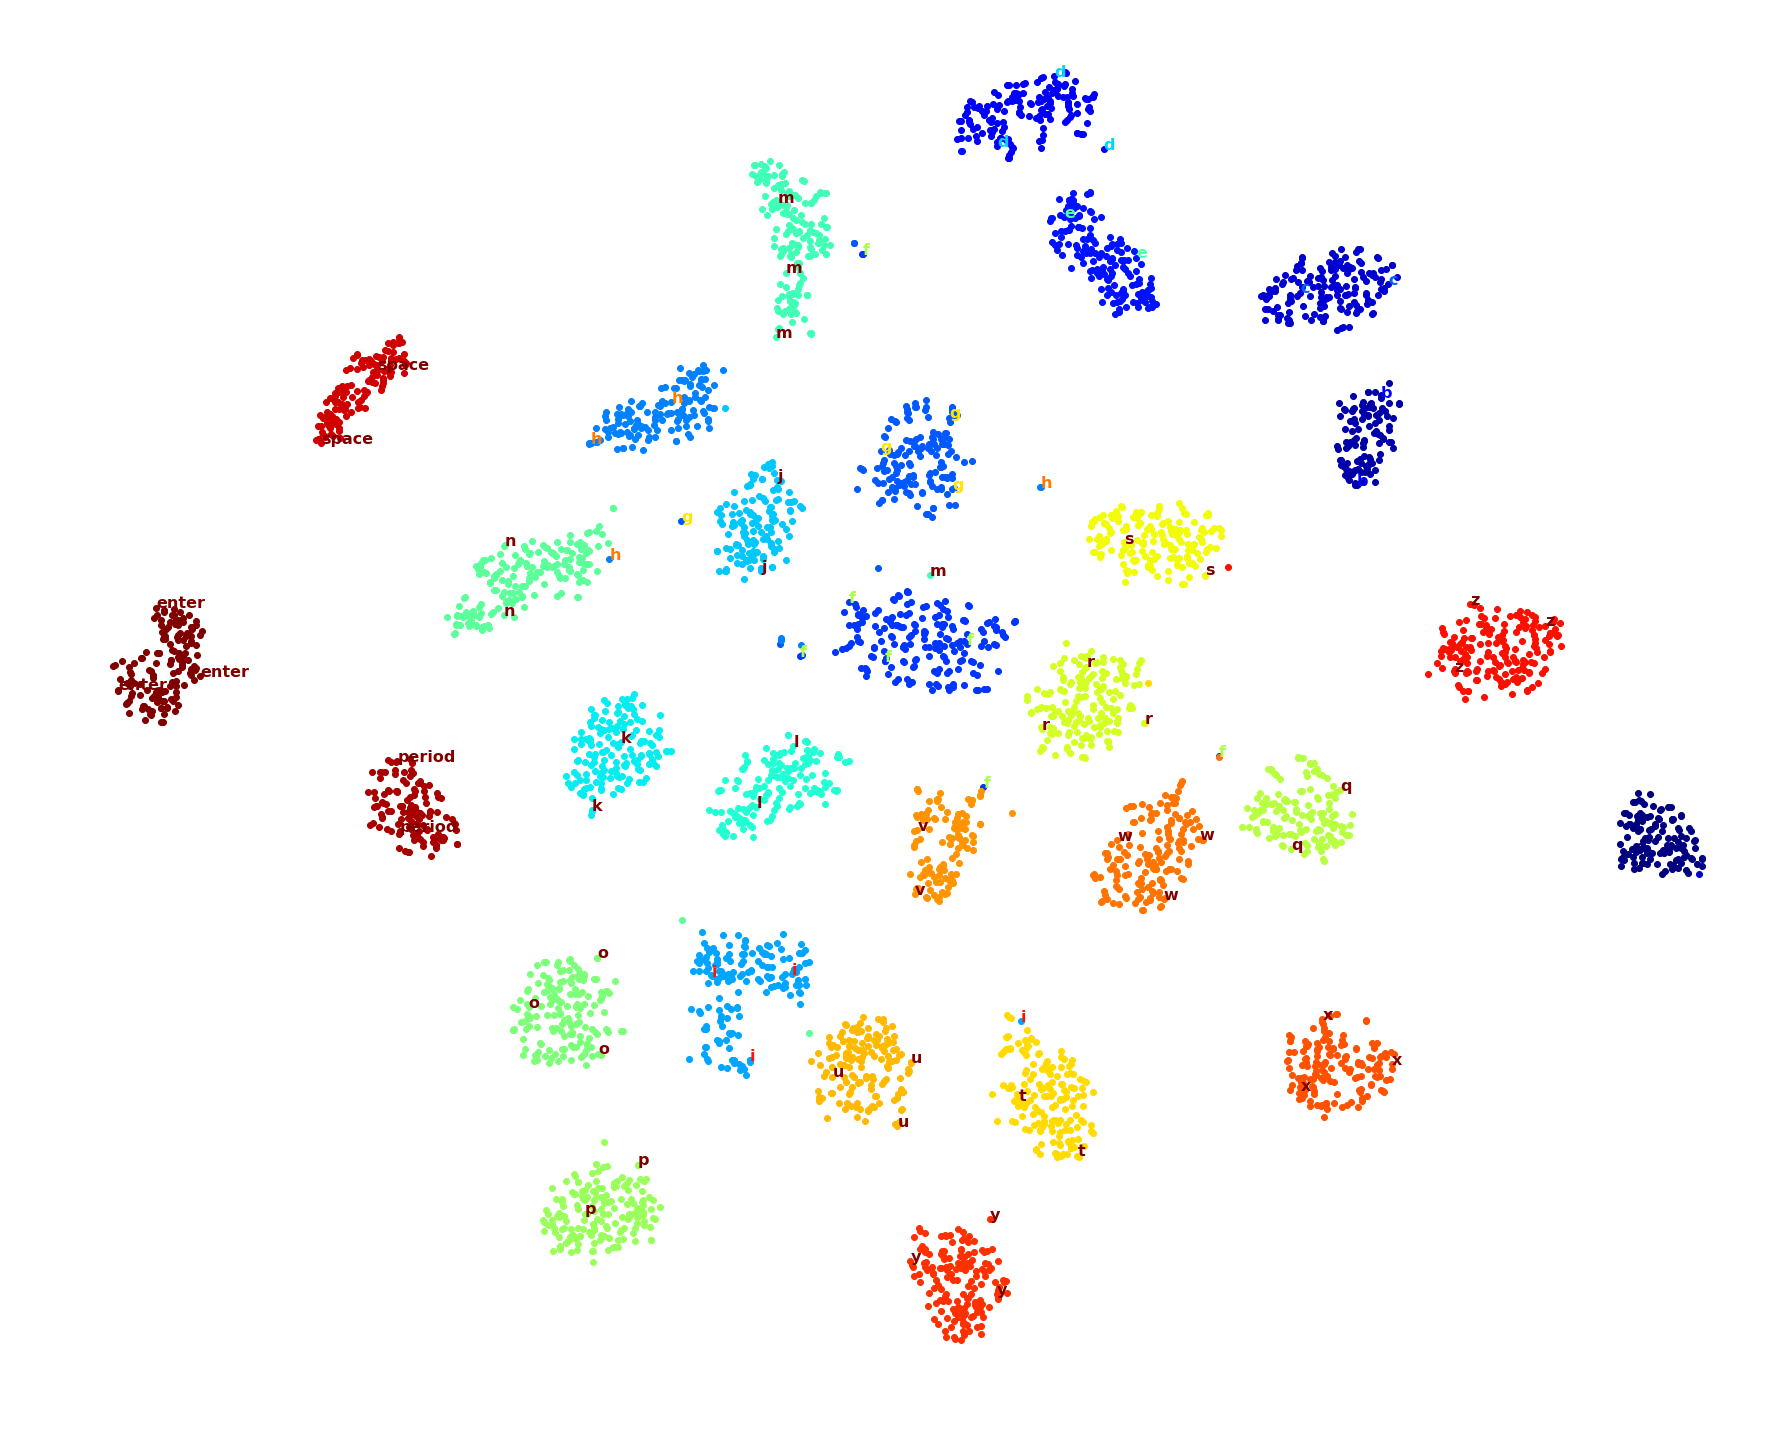

In [28]:
plot_keystrokes(data_embedded, labels_int, labels_str, figsize=(25, 20))
save_fig('tsne-success2')

Finally clustered!! (May 22, 2019)

## Supervised training with MFCCs

In [5]:
data, labels_int, labels_str = load_keystroke_data(os.environ['TEST_DATABASE_URL'])

In [35]:
processed_data = np.array([extract_features(key) for key in data])
scaled_data = MinMaxScaler().fit_transform(processed_data)
training_count = int(len(scaled_data) * 0.9)
x_train, x_test = scaled_data[:training_count], scaled_data[training_count:]
y_train, y_test = labels_int[:training_count], labels_int[training_count:]

/usr/local/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
3987/3987 [==============================] - 0s 104us/sample - loss: 3.0030 - accuracy: 0.1452
Epoch 2/5
3987/3987 [==============================] - 0s 83us/sample - loss: 1.5549 - accuracy: 0.5207
Epoch 3/5
3987/3987 [==============================] - 0s 82us/sample - loss: 0.6925 - accuracy: 0.7986
Epoch 4/5
3987/3987 [==============================] - 0s 78us/sample - loss: 0.3879 - accuracy: 0.8909
Epoch 5/5
444/444 [==============================] - 0s 127us/sample - loss: 17.4095 - accuracy: 0.1014


[17.409512532186938, 0.10135135]

The model seems to be severely overfitting the data, but a huge improvement can be seen compared to the initial attempt with no preprocessing.

#### Attempting classifier with t-SNE'd vectors

In [31]:
t0 = time.time()
data_embedded = TSNE().fit_transform(scaled_data)
t1 = time.time()
print(f'Total time elapsed: {t1 - t0}s')

Total time elapsed: 74.58113646507263s


In [32]:
training_count = int(len(scaled_data) * 0.9)
x_train, x_test = data_embedded[:training_count], data_embedded[training_count:]
y_train, y_test = labels_int[:training_count], labels_int[training_count:]

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(29, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
3987/3987 [==============================] - 0s 97us/sample - loss: 2.9812 - accuracy: 0.1635
Epoch 2/5
3987/3987 [==============================] - 0s 88us/sample - loss: 1.7372 - accuracy: 0.5167
Epoch 3/5
3987/3987 [==============================] - 0s 79us/sample - loss: 0.9257 - accuracy: 0.7698
Epoch 4/5
3987/3987 [==============================] - 0s 80us/sample - loss: 0.5291 - accuracy: 0.8816
Epoch 5/5
444/444 [==============================] - 0s 119us/sample - loss: 17.2794 - accuracy: 0.1014


[17.27942925960094, 0.10135135]

### Conclusion   
Data clustered very neatly, but classifier overfits severely. A neural network may not be the right approach for the current circumstances, as there is likely not enough data to train the model properly. I will instead run experiments with more traditional clustering-based approaches.